In [324]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from shifterator import shifts
import re
import itertools
import collections
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
import numpy as np
import scipy.stats as stats
from scipy.stats import entropy

In [325]:
rfc_df = pd.read_csv('../data/rfc.csv')
comment_df = pd.read_csv('../data/rfc_comments.csv')
user_json = "../data/json_files/user_info/users.json"
with open(user_json) as f:
    users = json.load(f)
users_df = pd.DataFrame(users)

# Data Exploration

In [326]:
rfc_df.head()

,page_id,rfc_id,page_title,discussion_input_comment,project,closing_date
0,29488,0,Talk:Skyscraper,0,wikipedia,2021-01-05T06:57:00Z
1,22415346,1,Talk:Bell Media Radio,35,wikipedia,2019-12-18T03:35:00Z
2,55480246,2,Talk:Noah Kraft,38,wikipedia,2019-10-11T09:04:00Z
3,55480246,3,Talk:Noah Kraft,64,wikipedia,2019-10-11T09:04:00Z
4,66698580,4,Wikipedia:Reliable sources/Noticeboard/Archive...,90,wikipedia,2021-02-03T21:13:00Z


In [327]:
comment_df = comment_df.rename(columns={'user': 'user_name'})
comment_df.head()

,date,id,parent_id,section,text,user_name,project,rfc_id,page_title,page_id,language
0,2020-10-06T13:22:00Z,0,0,NaN,There is a disagreement regarding the defintio...,Robynthehode,wikipedia,0,Talk:Skyscraper,29488,en
1,2020-10-07T06:22:00Z,1,0,==Summary of discussion==,The main contention is whether to include a si...,Robynthehode,wikipedia,0,Talk:Skyscraper,29488,en
2,2020-10-06T16:03:00Z,2,1,==Summary of discussion==,"It is not our purpose to define a term, but to...",Redrose64,wikipedia,0,Talk:Skyscraper,29488,en
3,2020-10-06T16:27:00Z,3,2,==Summary of discussion==,Thanks for your response. All the editors cont...,Robynthehode,wikipedia,0,Talk:Skyscraper,29488,en
4,2020-10-06T18:15:00Z,4,3,==Summary of discussion==,"What, all 32,000+ characters (excluding sigs a...",Redrose64,wikipedia,0,Talk:Skyscraper,29488,en


In [328]:
users_df.head()

,user_id,user_name,user_real_name,seconds_between_regdate_and_first_edit_date,isDeleted,user_registration,editcount,permissions
0,910196.0,Robynthehode,,1715797.0,False,2009-02-15T15:47:20,"{'mediawikiwiki': 0, 'metawiki': 0, 'wikidataw...","{'mediawikiwiki': 'user', 'metawiki': 'user', ..."
1,187002.0,Redrose64,,791.0,False,2009-05-05T12:46:21,"{'mediawikiwiki': 22, 'metawiki': 1981, 'wikid...","{'mediawikiwiki': 'user', 'metawiki': 'autopat..."
2,2641273.0,SportingFlyer,,300.0,False,2005-12-29T05:11:26,"{'mediawikiwiki': 0, 'metawiki': 1, 'wikidataw...","{'mediawikiwiki': 'user', 'metawiki': 'user', ..."
3,427425.0,Jirka.h23,,1535546.0,False,2009-07-23T14:11:10,"{'mediawikiwiki': 0, 'metawiki': 0, 'wikidataw...","{'mediawikiwiki': 'user', 'metawiki': 'user', ..."
4,958820.0,MelbourneStar,,2265847.0,False,2010-11-21T01:57:52,"{'mediawikiwiki': 1, 'metawiki': 5, 'wikidataw...","{'mediawikiwiki': 'user', 'metawiki': 'user', ..."


In [329]:
print(f'There are {len(rfc_df)} individual rfc')
print(f'There are {len(comment_df)} individual commments')
print(f'there are {len(users_df)} individual users')

There are 2302 individual rfc
There are 92254 individual commments
there are 8395 individual users


In [330]:
print(len(rfc_df[rfc_df['project'] == 'wikipedia']))
print(len(rfc_df[rfc_df['project'] == 'wikidata']))
print(len(rfc_df[rfc_df['project'] == 'meta.wikimedia']))

1552
140
610


In [331]:
print(f"{len(users_df[users_df['editcount'].isna()])} users do not exist in database anymore " )

588 users do not exist in database anymore 


Sum all wikipedia edit count to one value

In [332]:
# define list of wikis to include
wikis_to_include = ['enwiki','eswiki','frwiki','dewiki','zhwiki','jawiki','plwiki','ruwiki','itwiki','nlwiki','ptwiki']

# create new column with sum of edit counts for desired wikis
def sum_edit_counts(edit_count_dict, wikis_to_include):
    try:
        if edit_count_dict:
            edit_count_dict['wikipedia_project_sum'] = sum(edit_count_dict[wiki] for wiki in wikis_to_include)
            return edit_count_dict
        else:
            return edit_count_dict
    except KeyError:
        print(edit_count_dic)

users_df['editcount'] = users_df['editcount'].apply(lambda x: sum_edit_counts(x, wikis_to_include))

In [333]:
# drop rows with any NA values
users_df = users_df.dropna()
# projects to calculate median edit count for
projects = ['metawiki', 'wikidatawiki', 'wikipedia_project_sum']

# create list of edit counts for each project
edit_counts = [[d.get(p, 0) for d in users_df['editcount']] for p in projects]

# calculate median edit count for each project
median_edit_counts = [pd.Series(ec).median() for ec in edit_counts]
for i, p in enumerate(projects):
    print(f"The median edit count for {p} is {median_edit_counts[i]}")

The median edit count for metawiki is 9.0
The median edit count for wikidatawiki is 46.0
The median edit count for wikipedia_project_sum is 9415.5


In [334]:
# convert registration_date to datetime object
users_df['user_registration'] = pd.to_datetime(users_df['user_registration'])

# calculate account age
users_df['account_age'] = (datetime.now() - users_df['user_registration']).dt.days

median_account_age = users_df['account_age'].median()

print(f"The median account age is {median_account_age} days")

The median account age is 4971.5 days


## Participants

# Participants per RfC

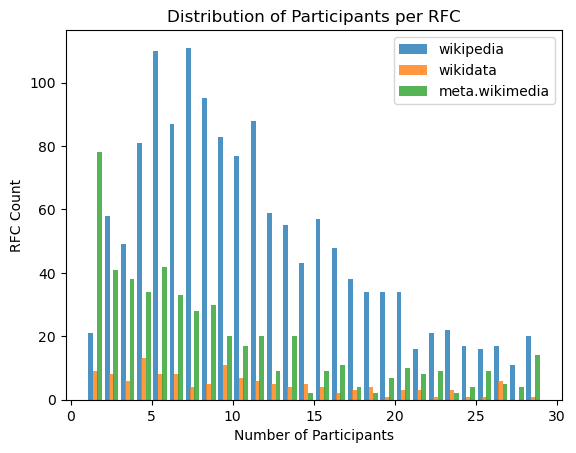

In [335]:
import seaborn as sns
# merge comment dataframe with RFC dataframe
merged_df = pd.merge(comment_df, rfc_df, on='rfc_id')
grouped = merged_df.groupby(['project_x', 'rfc_id'])['user_name'].nunique().reset_index(name='participants')

pivoted = grouped.pivot(index='rfc_id', columns='project_x', values='participants').fillna(0)

plt.hist([pivoted['wikipedia'], pivoted['wikidata'], pivoted['meta.wikimedia']], bins=range(1, 30), stacked=False, label=['wikipedia', 'wikidata', 'meta.wikimedia'],width=0.3,alpha = 0.8, align='mid')
plt.legend()
# Add a title to the plot
plt.title('Distribution of Participants per RFC')

# Add a label to the x-axis
plt.xlabel('Number of Participants')

# Add a label to the y-axis
plt.ylabel('RFC Count')
plt.show()

# Roles count per Project

In [336]:
# Define the order of roles
roles = ['sysop', 'bureaucrat', 'user']

# Define a function to map the values in the dictionary to the roles
def map_permissions_to_role(permissions_dic):
    for role in roles:
        if role in permissions_dic.values():
            return role
    return None

# Apply the function to the permissions_dic column to create the new role column
users_df['role'] = users_df['permissions'].apply(map_permissions_to_role)

In [337]:
users_df.groupby(["role"]).count()["user_id"]

role
bureaucrat      56
sysop          290
user          6822
Name: user_id, dtype: int64

# Diversity of RfC groups

In [338]:
users_df['editcount']

0       {'mediawikiwiki': 0, 'metawiki': 0, 'wikidataw...
1       {'mediawikiwiki': 22, 'metawiki': 1981, 'wikid...
2       {'mediawikiwiki': 0, 'metawiki': 1, 'wikidataw...
3       {'mediawikiwiki': 0, 'metawiki': 0, 'wikidataw...
4       {'mediawikiwiki': 1, 'metawiki': 5, 'wikidataw...
                              ...                        
8388    {'mediawikiwiki': 1, 'metawiki': 9, 'wikidataw...
8390    {'mediawikiwiki': 0, 'metawiki': 19, 'wikidata...
8391    {'mediawikiwiki': 4, 'metawiki': 19, 'wikidata...
8392    {'mediawikiwiki': 0, 'metawiki': 80, 'wikidata...
8393    {'mediawikiwiki': 9, 'metawiki': 612, 'wikidat...
Name: editcount, Length: 7168, dtype: object

In [339]:
def count_projects_above_50(editcounts):
    if editcounts is None:
        return 0
    num_above_50 = sum(count > 50 for project, count in editcounts.items() if project != 'wikipedia_project_sum')
    return num_above_50

users_df['num_projects_above_50'] = users_df['editcount'].apply(count_projects_above_50)

In [340]:
#Add total_editcount to user
# List of keys to sum editcounts for
keys_to_sum = ['wikipedia_project_sum','wikidatawiki','metawiki']

# Define a function to extract the desired editcounts from a dictionary
def extract_editcounts(editcount_dict, keys):
    return sum(editcount_dict.get(key) for key in keys)

# Apply the function to each row of the dataframe and sum up the results
users_df['total_editcount'] = users_df['editcount'].apply(extract_editcounts, args=(keys_to_sum,))


In [341]:
merged_df = comment_df.merge(users_df, on='user_name')
# group by rfc
grouped = merged_df.groupby('rfc_id')

# calculate total number of users per rfc
total_users = grouped['user_name'].count()

# calculate frequency of each unique combination of role, account age, and edit_count per rfc
freq = grouped.apply(lambda x: x.groupby(['role', 'account_age', 'total_editcount', 'num_projects_above_50'])['user_name'].count())

# calculate probability of each unique combination of role, account age, and edit_count per rfc
prob = freq / total_users

# calculate entropy for each rfc
entropy = - (prob * np.log2(prob)).groupby('rfc_id').sum()
entropy.name = 'entropy'

print(entropy)

rfc_id
0       1.891909
1       0.918296
2       2.848941
3       2.848941
4       3.143759
          ...   
2297    3.844969
2298    3.546594
2299    2.251629
2300    2.865749
2301    4.610900
Name: entropy, Length: 2266, dtype: float64


In [342]:
# merge the entropy values with the original dataframe
merged_df = pd.merge(rfc_df, entropy, on='rfc_id')

# calculate the average entropy per column based on the 'project' column
avg_entropy = merged_df.groupby('project')['entropy'].mean()

print(avg_entropy)

project
meta.wikimedia    2.535758
wikidata          2.627441
wikipedia         2.832819
Name: entropy, dtype: float64


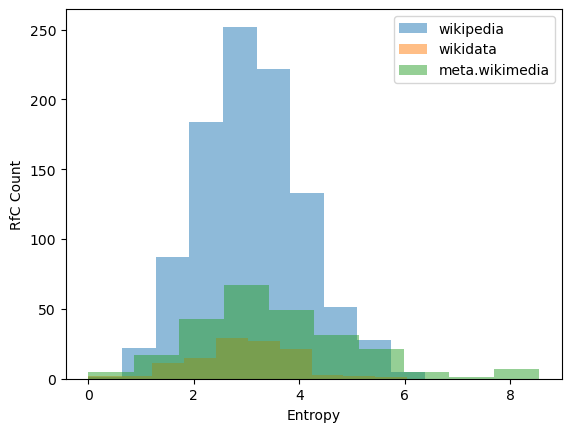

In [343]:
grouped = merged_df.groupby(['project', 'entropy']).size().reset_index(name='count')

# Get a list of all projects
projects = merged_df['project'].unique()

# Plot a histogram for each project
for project in projects:
    # Get the subset of data for this project
    subset = grouped[grouped['project'] == project]
    
    # Plot the histogram
    plt.hist(subset['entropy'], bins=10, alpha=0.5, label=project)

# Add axis labels and a legend
plt.xlabel('Entropy')
plt.ylabel('RfC Count')
plt.legend()

# Show the plot
plt.show()

In [344]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array = array + 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [345]:
merged_df = comment_df.merge(users_df, on='user_name')
# group the dataframe by 'rfc_id'
grouped = merged_df.groupby('rfc_id')

# define the function to calculate Gini number-based diversity measures for each group using Hill–Shannon diversity
def gini_diversity(group):
    age_diversity = gini(group['account_age'].values)
    edit_diversity = gini(group['total_editcount'].values)
    num_of_projects_editcount_50_diversity = gini(group['num_projects_above_50'].values)
    # Convert the role column to numerical values
    role_dict = {'sysop': 2, 'bureaucrat': 1, 'user': 0}
    group['role'] = group['role'].map(role_dict)
    role_diversity = gini(group['role'].values)
    # return a dictionary with the diversity measures for user roles, account age, and edit count
    return {'role_diversity': role_diversity, 'age_diversity': age_diversity, 'edit_diversity': edit_diversity, 'num_of_projects_editcount_50_diversity' : num_of_projects_editcount_50_diversity}

 # apply the function to each group in the grouped dataframe for each q value
gini_diversity_df = pd.DataFrame(grouped.apply(gini_diversity))   

In [346]:
gini_diversity_df[0][15]

{'role_diversity': 5.401995837080998e-18,
 'age_diversity': 0.2403459033740472,
 'edit_diversity': 0.8553023545782674,
 'num_of_projects_editcount_50_diversity': 0.3253246587626927}

In [347]:
merged_df = comment_df.merge(users_df, on='user_name')
# group the dataframe by 'rfc_id'
grouped = merged_df.groupby('rfc_id')

# define the function to calculate Hill number-based diversity measures for each group using Hill–Shannon diversity
def shannon_diversity(group):
    # calculate the proportions of each user role, mean account age, and mean edit count in the group
    role_proportions = group['role'].value_counts(normalize=True)
    age_proportions = group['account_age'] / group['account_age'].sum()
    edit_proportions = group['total_editcount'] / group['total_editcount'].sum()
    num_of_projects_editcount_50_proportions = group['num_projects_above_50'] / group['num_projects_above_50'].sum()

    # add a small value to the proportions to prevent division by zero
    epsilon = 1e-10
    role_proportions = role_proportions + epsilon
    age_proportions = age_proportions + epsilon
    edit_proportions = edit_proportions + epsilon
    num_of_projects_editcount_50_proportions = num_of_projects_editcount_50_proportions + epsilon
    

    # calculate the Hill number-based diversity measures for the user roles, account age, and edit count
    role_diversity = - np.sum(role_proportions * np.log2(role_proportions))
    age_diversity = - np.sum(age_proportions * np.log2(age_proportions))
    edit_diversity = - np.sum(edit_proportions * np.log2(edit_proportions))
    num_of_projects_editcount_50_diversity = - np.sum(num_of_projects_editcount_50_proportions * np.log2(num_of_projects_editcount_50_proportions))
    
    # return a dictionary with the diversity measures for user roles, account age, and edit count
    return {'role_diversity': role_diversity, 'age_diversity': age_diversity, 'edit_diversity': edit_diversity, 'num_of_projects_editcount_50_diversity' : num_of_projects_editcount_50_diversity}

# apply the function to each group in the grouped dataframe for each q value
shannon_diversity_each_metric_df = pd.DataFrame(grouped.apply(shannon_diversity))

In [348]:
print(shannon_diversity_each_metric_df)

                                                        0
rfc_id                                                   
0       {'role_diversity': -1.4426951603302212e-10, 'a...
1       {'role_diversity': -1.4426951603302212e-10, 'a...
2       {'role_diversity': -1.4426951603302212e-10, 'a...
3       {'role_diversity': -1.4426951603302212e-10, 'a...
4       {'role_diversity': -1.4426951603302212e-10, 'a...
...                                                   ...
2297    {'role_diversity': 0.32474774763147585, 'age_d...
2298    {'role_diversity': 0.8904916401540477, 'age_di...
2299    {'role_diversity': 0.918295833982943, 'age_div...
2300    {'role_diversity': -1.4426951603302212e-10, 'a...
2301    {'role_diversity': 0.32833891228109385, 'age_d...

[2266 rows x 1 columns]


In [349]:
rfc_df_gini = rfc_df.merge(gini_diversity_df, on='rfc_id')

In [350]:
rfc_df = rfc_df.merge(shannon_diversity_each_metric_df, on='rfc_id')

In [351]:
# use apply and lambda to extract dictionary values to columns
rfc_df_gini[['role_diversity', 'age_diversity', 'edit_diversity', 'num_of_projects_editcount_50_diversity']] = rfc_df_gini[0].apply(lambda x: pd.Series({'role_diversity': x['role_diversity'], 'age_diversity': x['age_diversity'], 'edit_diversity': x['edit_diversity'], 'num_of_projects_editcount_50_diversity' : x['num_of_projects_editcount_50_diversity']}))

# drop the original dictionary column
rfc_df_gini = rfc_df_gini.drop(0, axis=1)

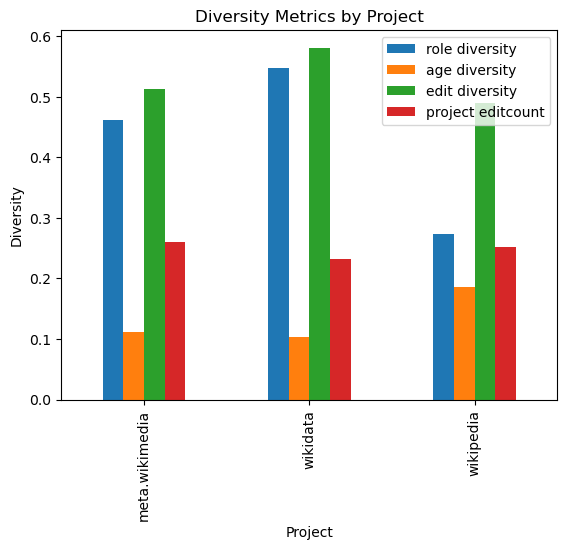

In [352]:
# group the DataFrame by project and calculate the mean of each diversity metric
filtered_df = rfc_df_gini.filter(['project', 'role_diversity', 'age_diversity', 'edit_diversity', 'num_of_projects_editcount_50_diversity'])
grouped_df = filtered_df.groupby('project').mean()

# plot the diversity metrics for each project
grouped_df.plot(kind='bar')
plt.legend(('role diversity', 'age diversity', 'edit diversity', 'project editcount'), loc='upper right', shadow=False)
plt.title('Diversity Metrics by Project')
plt.xlabel('Project')
plt.ylabel('Diversity')
plt.show()

In [353]:
# use apply and lambda to extract dictionary values to columns
rfc_df[['role_diversity', 'age_diversity', 'edit_diversity', 'num_of_projects_editcount_50_diversity']] = rfc_df[0].apply(lambda x: pd.Series({'role_diversity': x['role_diversity'], 'age_diversity': x['age_diversity'], 'edit_diversity': x['edit_diversity'], 'num_of_projects_editcount_50_diversity' : x['num_of_projects_editcount_50_diversity']}))

# drop the original dictionary column
rfc_df = rfc_df.drop(0, axis=1)

In [354]:
rfc_df['metric_diversity'] = rfc_df[['role_diversity', 'age_diversity', 'edit_diversity', 'num_of_projects_editcount_50_diversity']].sum(axis=1)

In [355]:
rfc_df

,page_id,rfc_id,page_title,discussion_input_comment,project,closing_date,role_diversity,age_diversity,edit_diversity,num_of_projects_editcount_50_diversity,metric_diversity
0,29488,0,Talk:Skyscraper,0,wikipedia,2021-01-05T06:57:00Z,-1.442695e-10,5.036681,3.815629,4.822757,13.675066
1,22415346,1,Talk:Bell Media Radio,35,wikipedia,2019-12-18T03:35:00Z,-1.442695e-10,1.569832,0.493108,1.500000,3.562940
2,55480246,2,Talk:Noah Kraft,38,wikipedia,2019-10-11T09:04:00Z,-1.442695e-10,4.513882,2.911315,4.536670,11.961867
3,55480246,3,Talk:Noah Kraft,64,wikipedia,2019-10-11T09:04:00Z,-1.442695e-10,4.513882,2.911315,4.536670,11.961867
4,66698580,4,Wikipedia:Reliable sources/Noticeboard/Archive...,90,wikipedia,2021-02-03T21:13:00Z,-1.442695e-10,6.319445,6.012831,6.083699,18.415975
...,...,...,...,...,...,...,...,...,...,...,...
2261,12004180,2297,Requests for comment/Global ban for Александр ...,98326,meta.wikimedia,2022-12-02T20:49:00Z,3.247477e-01,6.743390,6.252472,6.719777,20.040386
2262,12008264,2298,Requests for comment/Make all new wikis global...,98593,meta.wikimedia,2022-11-12T10:16:00Z,8.904916e-01,3.506100,2.565470,3.642813,10.604875
2263,12029281,2299,Requests for comment/Global ban for Trieu Thua...,98618,meta.wikimedia,NaN,9.182958e-01,2.088527,1.358082,2.289343,6.654248
2264,12032443,2300,Requests for comment/Global ban for Planespott...,98624,meta.wikimedia,2022-12-01T13:39:00Z,-1.442695e-10,4.176763,4.073001,4.383773,12.633538


In [356]:
from scipy.stats import shapiro
from scipy.stats import kstest

# Perform Shapiro-Wilk test
result = kstest(rfc_df['metric_diversity'],'norm')

# Print the test statistic and p-value
print("Test statistic:", result.statistic)
print("p-value:", result.pvalue)

Test statistic: 0.9324736280416426
p-value: 0.0


wikipedia: Data is not normally distributed (reject H0)


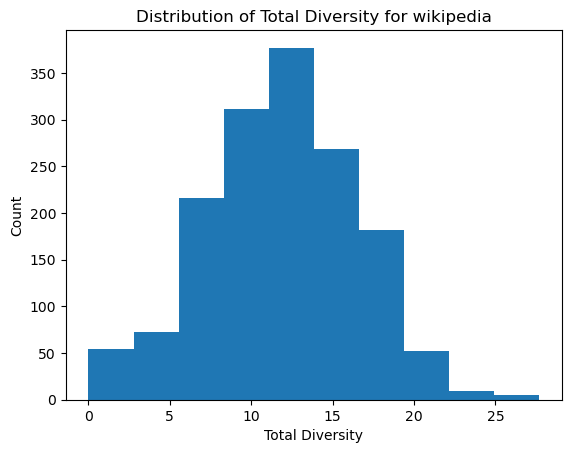

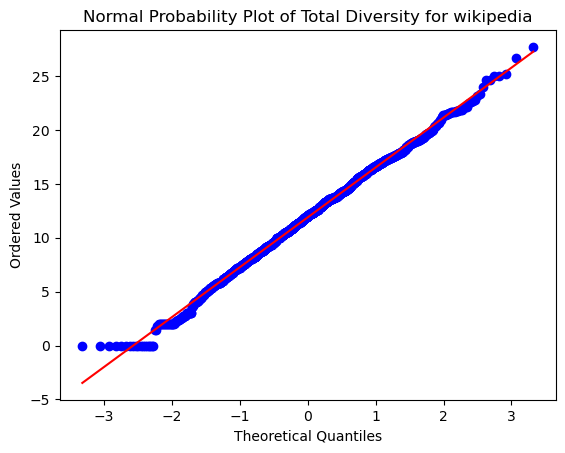

wikidata: Data is not normally distributed (reject H0)


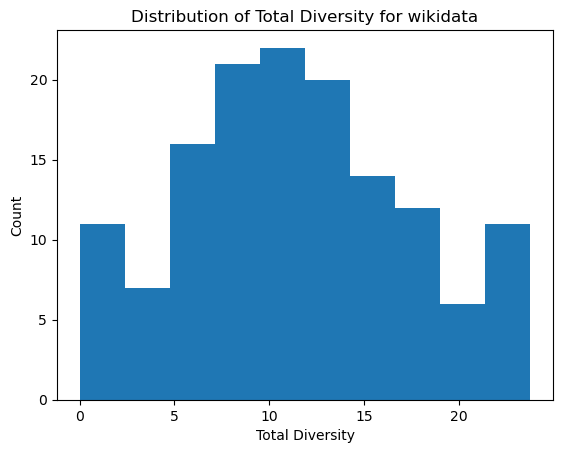

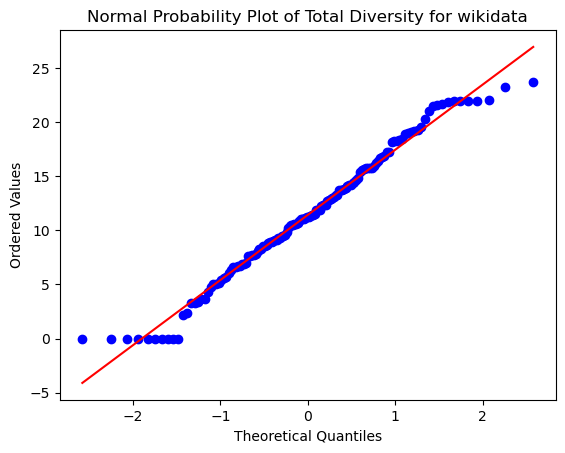

meta.wikimedia: Data is not normally distributed (reject H0)


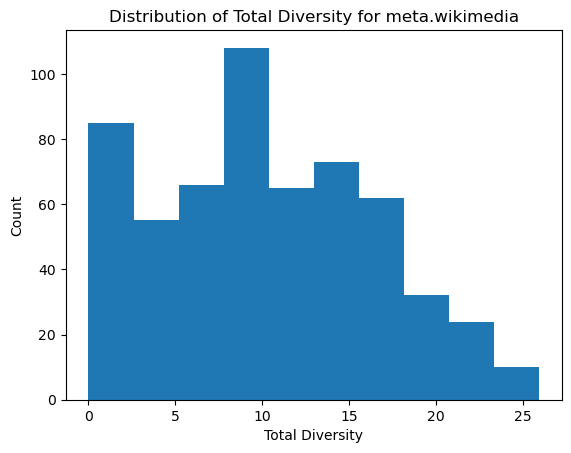

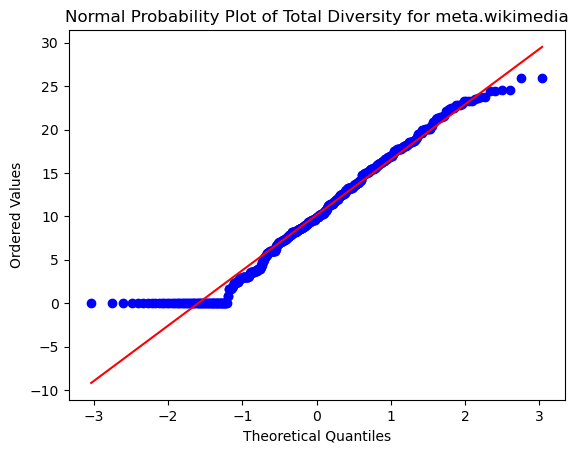

In [357]:
import matplotlib.pyplot as plt
from scipy.stats import kstest

# Loop through each project
for project in rfc_df['project'].unique():

    # Select data for current project
    project_data = rfc_df[rfc_df['project'] == project]['metric_diversity']

    # Perform Shapiro-Wilk test
    stat, p = kstest(project_data, cdf ='norm')

    # Interpret the results
    alpha = 0.05
    if p > alpha:
        print(f'{project}: Data is normally distributed (fail to reject H0)')
    else:
        print(f'{project}: Data is not normally distributed (reject H0)')

    # Create histogram
    plt.hist(project_data)

    # Add labels and title
    plt.xlabel('Total Diversity')
    plt.ylabel('Count')
    plt.title(f'Distribution of Total Diversity for {project}')

    # Show plot
    plt.show()

    # Create normal probability plot
    probplot(project_data, plot=plt)

    # Add labels and title
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Ordered Values')
    plt.title(f'Normal Probability Plot of Total Diversity for {project}')

    # Show plot
    plt.show()


In [358]:
entropy = rfc_df

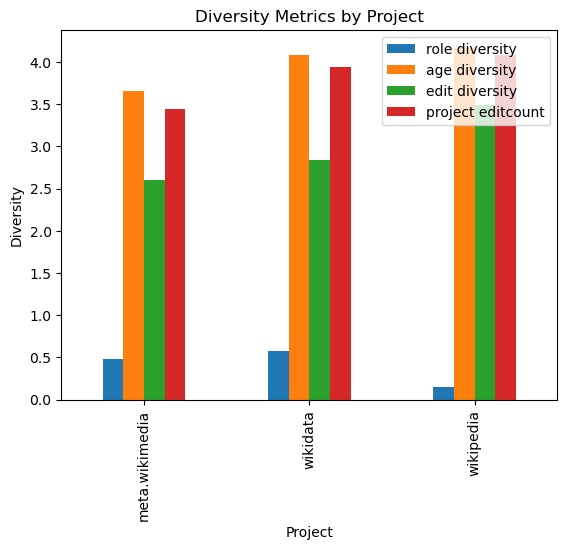

In [359]:
# group the DataFrame by project and calculate the mean of each diversity metric
filtered_df = rfc_df.filter(['project', 'role_diversity', 'age_diversity', 'edit_diversity', 'num_of_projects_editcount_50_diversity'])
grouped_df = filtered_df.groupby('project').mean()

# plot the diversity metrics for each project
grouped_df.plot(kind='bar')
plt.legend(('role diversity', 'age diversity', 'edit diversity', 'project editcount'), loc='upper right', shadow=False)
plt.title('Diversity Metrics by Project')
plt.xlabel('Project')
plt.ylabel('Diversity')
plt.show()

In [360]:
test = entropy

## Content

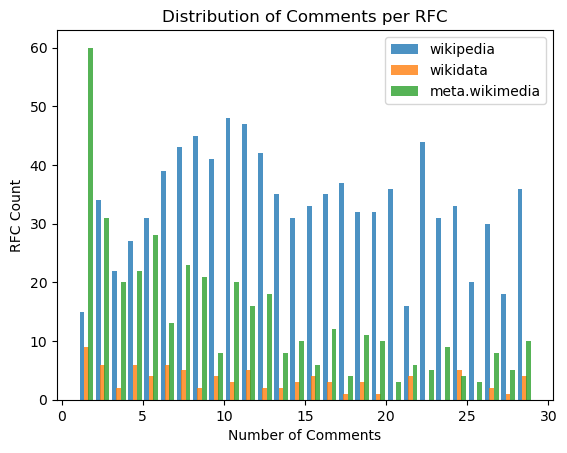

In [361]:
# merge comment dataframe with RFC dataframe
grouped = comment_df.groupby(['project', 'rfc_id'])['text'].count().reset_index(name='comments')

pivoted = grouped.pivot(index='rfc_id', columns='project', values='comments').fillna(0)

plt.hist([pivoted['wikipedia'], pivoted['wikidata'], pivoted['meta.wikimedia']], bins=range(1, 30),alpha=0.8, stacked=False, label=['wikipedia', 'wikidata', 'meta.wikimedia'],width=0.3)
plt.legend()
# Add a title to the plot
plt.title('Distribution of Comments per RFC')

# Add a label to the x-axis
plt.xlabel('Number of Comments')

# Add a label to the y-axis
plt.ylabel('RFC Count')
plt.show()

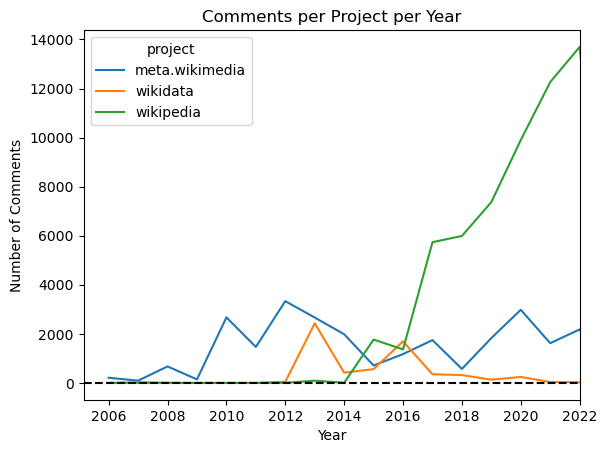

In [362]:
# convert date column to datetime format2
comment_df['date'] = pd.to_datetime(comment_df['date'])

# extract the year from date column and create a new column
comment_df['year'] = comment_df['date'].dt.year

# Group the dataframe by project and year, and count the number of comments
counts = comment_df.groupby(["project", "year"]).size().reset_index(name="count")

# Pivot the counts dataframe to have projects as columns and years as rows
pivoted = counts.pivot(index="year", columns="project", values="count")

# Fill missing values with 0
pivoted = pivoted.fillna(0)


# Plot the pivoted dataframe as a line chart
ax = pivoted.plot(kind="line")
# Add a horizontal line at y=0
ax.axhline(y=0, color="black", linestyle="--")
# Set the x axis limit to 2023
ax.set_xlim(left=None, right=2022)
ax.set_xlabel("Year")
ax.set_ylabel("Number of Comments")
# Add a title to the plot
plt.title('Comments per Project per Year')
plt.show()

## Deliberation

In [379]:
deliberation_df = pd.read_csv('../data/final_rfc_statements_02052023.csv')
#deliberation_df = deliberation_df.drop('question', axis=1)
rfc_df = pd.read_csv('../data/rfc.csv')

In [380]:
def checkLabel(label):
    if label == "LABEL_1" or label == "LABEL_2" or label == "LABEL_3":
        return 1
    else:
        return 0

deliberation_df['toxicity_int'] = deliberation_df['toxicity'].apply(checkLabel)

In [381]:
deliberation_df

,speaker,char_count,has_respect,has_question,has_question_parent,gender,narrative,question,response,advocacy,...,text,user,project,rfc_id,page_title,page_id,toxicity,text_length,explanation_lr,toxicity_int
0,Robynthehode,409,0,0,0,M,NaN,0.0,0.0,0.0,...,There is a disagreement regarding the defintio...,Robynthehode,wikipedia,0,Talk:Skyscraper,29488,LABEL_0,418,1,0
1,Robynthehode,571,0,0,0,M,NaN,0.0,1.0,1.0,...,The main contention is whether to include a si...,Robynthehode,wikipedia,0,Talk:Skyscraper,29488,LABEL_0,593,1,0
2,Redrose64,630,0,0,0,M,NaN,0.0,0.0,0.0,...,"It is not our purpose to define a term, but to...",Redrose64,wikipedia,0,Talk:Skyscraper,29488,LABEL_0,669,1,0
3,Robynthehode,315,1,0,0,M,NaN,0.0,1.0,0.0,...,Thanks for your response. All the editors cont...,Robynthehode,wikipedia,0,Talk:Skyscraper,29488,LABEL_0,321,1,0
4,Redrose64,236,0,1,0,M,NaN,0.0,0.0,0.0,...,"What, all 32,000+ characters (excluding sigs a...",Redrose64,wikipedia,0,Talk:Skyscraper,29488,LABEL_0,277,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92214,1234qwer1234qwer4,1331,0,0,0,M,NaN,0.0,1.0,1.0,...,***: You are still telling lies to all these p...,Lemonaka,meta.wikimedia,2301,Requests for comment/Global ban for Planespott...,12033142,LABEL_2,147,1,1
92215,Lemonaka,381,0,0,0,M,NaN,0.0,1.0,0.0,...,"****There must have been some mistake, because...",PlanespotterA320,meta.wikimedia,2301,Requests for comment/Global ban for Planespott...,12033142,LABEL_0,358,1,0
92216,Lemonaka,772,0,1,0,M,NaN,0.0,0.0,0.0,...,Maybe they use the same VPN as me?\n\n No ope...,SummerKrut,meta.wikimedia,2301,Requests for comment/Global ban for Planespott...,12033142,LABEL_0,62,1,0
92217,Lemonaka,1023,0,0,1,M,NaN,0.0,1.0,1.0,...,"hi, @[[User:SummerKrut|SummerKrut]], Thanks fo...",Lemonaka,meta.wikimedia,2301,Requests for comment/Global ban for Planespott...,12033142,LABEL_0,207,1,0


In [382]:
metric_list = [
    'question', 'response', 'advocacy', 'explanation_lr', 'causal_reasoning', 'narrative', 'toxicity_int'
]
# Calculate the row sum of the metrics and subtract the disrespect column
deliberation_df["DQI-Value"] = deliberation_df[metric_list].sum(axis=1) - deliberation_df['toxicity_int']

In [383]:
# Merge the comments DataFrame with the RFC DataFrame on the RFC ID column
merged_df = pd.merge(deliberation_df, rfc_df, on="rfc_id")

# Group the merged DataFrame by RFC ID and calculate the mean of the dqi_value column
mean_dqi_per_rfc = merged_df.groupby("rfc_id")["DQI-Value"].mean()


In [384]:
# Merge the mean dqi-value per RFC with the RFC DataFrame on the RFC ID column
delib_rfc_df = pd.merge(rfc_df, mean_dqi_per_rfc, on="rfc_id")

# Rename the column containing the mean dqi-value per RFC
delib_rfc_df = delib_rfc_df.rename(columns={"DQI-Value": "mean_dqi_value"})

In [385]:
delib_rfc_df.head()

,page_id,rfc_id,page_title,discussion_input_comment,project,closing_date,mean_dqi_value
0,29488,0,Talk:Skyscraper,0,wikipedia,2021-01-05T06:57:00Z,2.909091
1,22415346,1,Talk:Bell Media Radio,35,wikipedia,2019-12-18T03:35:00Z,1.666667
2,55480246,2,Talk:Noah Kraft,38,wikipedia,2019-10-11T09:04:00Z,2.115385
3,55480246,3,Talk:Noah Kraft,64,wikipedia,2019-10-11T09:04:00Z,2.115385
4,66698580,4,Wikipedia:Reliable sources/Noticeboard/Archive...,90,wikipedia,2021-02-03T21:13:00Z,1.933333


wikipedia: Data is not normally distributed (reject H0)


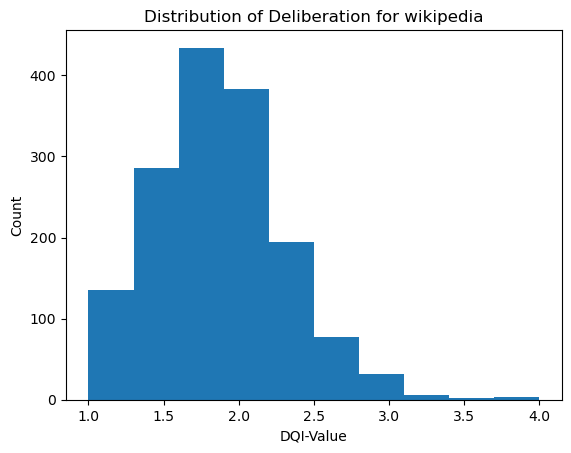

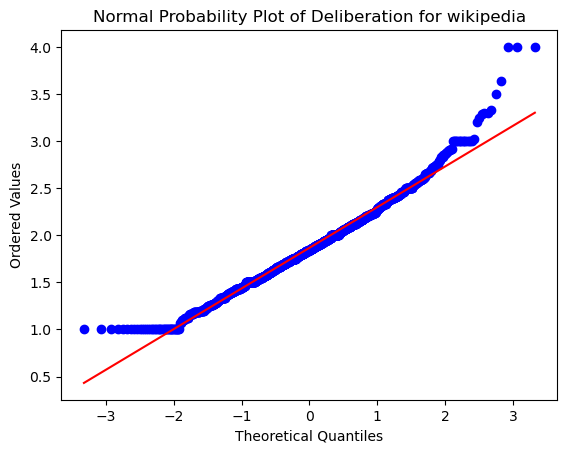

wikidata: Data is not normally distributed (reject H0)


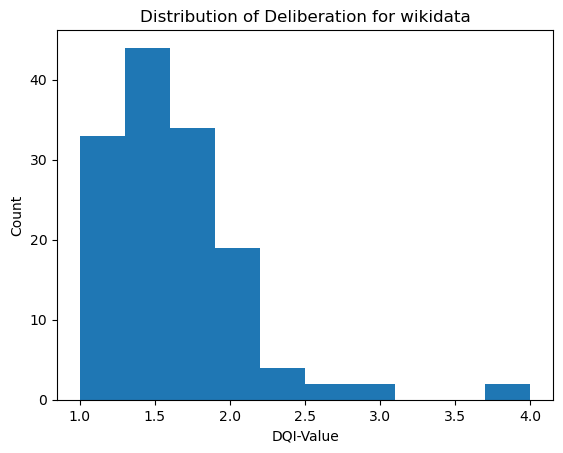

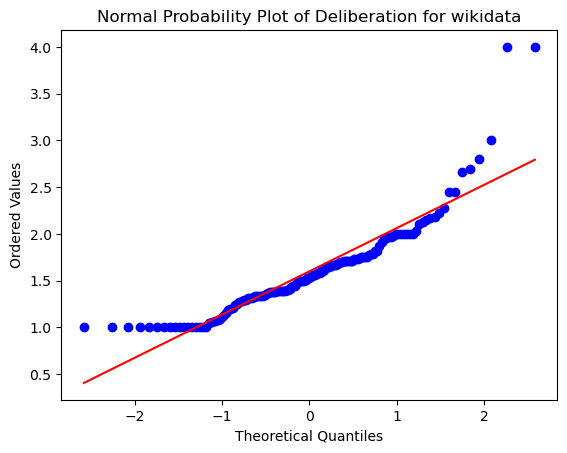

meta.wikimedia: Data is not normally distributed (reject H0)


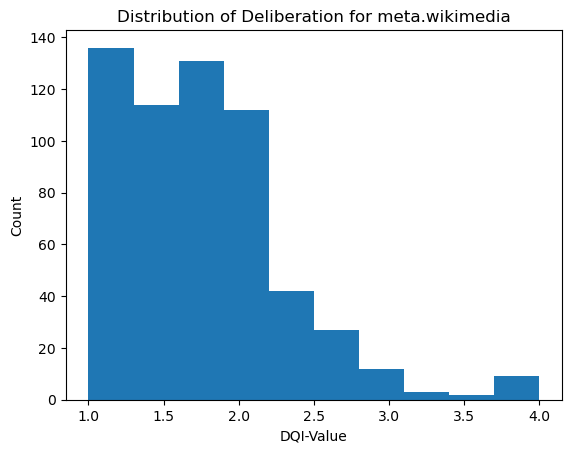

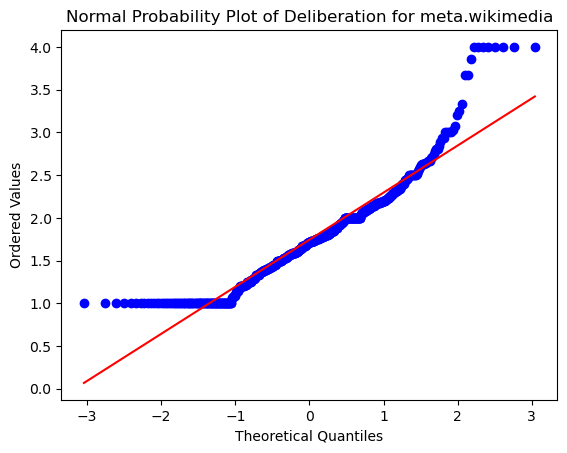

In [386]:
import matplotlib.pyplot as plt
from scipy.stats import kstest

# Loop through each project
for project in delib_rfc_df['project'].unique():

    # Select data for current project
    project_data = delib_rfc_df[delib_rfc_df['project'] == project]['mean_dqi_value']

    # Perform kor
    stat, p = kstest(project_data, cdf='norm')

    # Interpret the results
    alpha = 0.05
    if p > alpha:
        print(f'{project}: Data is normally distributed (fail to reject H0)')
    else:
        print(f'{project}: Data is not normally distributed (reject H0)')

    # Create histogram
    plt.hist(project_data)

    # Add labels and title
    plt.xlabel('DQI-Value')
    plt.ylabel('Count')
    plt.title(f'Distribution of Deliberation for {project}')

    # Show plot
    plt.show()

    # Create normal probability plot
    probplot(project_data, plot=plt)

    # Add labels and title
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Ordered Values')
    plt.title(f'Normal Probability Plot of Deliberation for {project}')

    # Show plot
    plt.show()


wikipedia has mean
1.9495129903432176
wikidata has mean
1.6569782903123482
meta.wikimedia has mean
1.8825749593767125


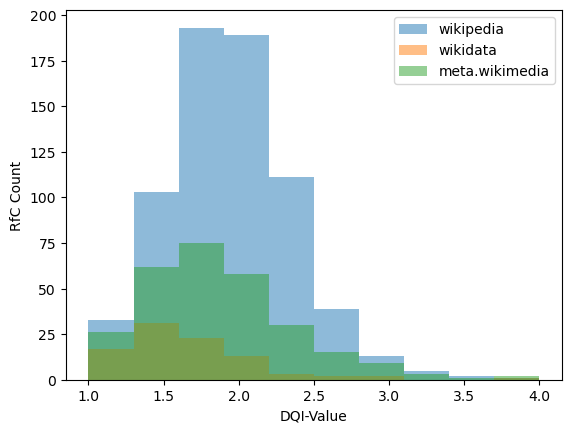

In [387]:
grouped = delib_rfc_df.groupby(['project', 'mean_dqi_value']).size().reset_index(name='count')

# Get a list of all projects
projects = delib_rfc_df['project'].unique()

# Plot a histogram for each project
for project in projects:
    # Get the subset of data for this project
    subset = grouped[grouped['project'] == project]
    print(project + ' has mean')
    print(subset['mean_dqi_value'].mean())
    # Plot the histogram
    plt.hist(subset['mean_dqi_value'], bins=10, alpha=0.5, label=project)

# Add axis labels and a legend
plt.xlabel('DQI-Value')
plt.ylabel('RfC Count')
plt.legend()

# Show the plot
plt.show()

In [388]:
# Group the RFC DataFrame by project and calculate the mean of the dqi_value column
grouped_rfc_df = delib_rfc_df.groupby("project")["mean_dqi_value"].mean()

In [389]:
print(grouped_rfc_df)

project
meta.wikimedia    1.743640
wikidata          1.600492
wikipedia         1.867094
Name: mean_dqi_value, dtype: float64


In [390]:
from scipy.stats import mannwhitneyu

# separate data by project
proj1 = delib_rfc_df.loc[rfc_df['project'] == 'wikipedia']['mean_dqi_value']
proj2 = delib_rfc_df.loc[rfc_df['project'] == 'wikidata']['mean_dqi_value']

# perform two-sample t-test
result = mannwhitneyu(proj1, proj2)

# Print the test statistic and p-value
print("Test statistic:", result.statistic)
print("p-value:", result.pvalue)

if result.pvalue < 0.05:
    print("There is a significant difference between wikipedia and wikidata.")
else:
    print("There is no significant difference between wikipedia and wikidata.")

Test statistic: 151142.5
p-value: 1.6271657330792833e-14
There is a significant difference between wikipedia and wikidata.


In [391]:

proj3 = delib_rfc_df.loc[delib_rfc_df['project'] == 'meta.wikimedia']['mean_dqi_value']
# perform two-sample t-test
result = mannwhitneyu(proj2, proj3)

# Print the test statistic and p-value
print("Test statistic:", result.statistic)
print("p-value:", result.pvalue)

if result.pvalue < 0.05:
    print("There is a significant difference between wikidata and meta.")
else:
    print("There is no significant difference between wikidata and meta.")

Test statistic: 34126.0
p-value: 0.0016314699826399657
There is a significant difference between wikidata and meta.


In [392]:
# perform two-sample t-test
result = mannwhitneyu(proj1, proj3)

# Print the test statistic and p-value
print("Test statistic:", result.statistic)
print("p-value:", result.pvalue)

if p_value < 0.05:
    print("There is a significant difference between wikipedia and meta.")
else:
    print("There is no significant difference between wikipedia and meta.")

Test statistic: 539718.0
p-value: 6.169670188097093e-11
There is a significant difference between wikipedia and meta.


In [393]:
'''
# calculate percentage of 1s for each column
percentages = (filtered_list.mean() * 100).round(2)

# print results
print(percentages)
'''

'\n# calculate percentage of 1s for each column\npercentages = (filtered_list.mean() * 100).round(2)\n\n# print results\nprint(percentages)\n'

# Support,Oppose,Comment,Neutral

In [395]:
def detect_sentiment(text):
    words = text.lower().split()[:5]
    if any(word.startswith("support") for word in words):
        return "support"
    elif any(word.startswith("oppose") for word in words):
        return "oppose"
    elif any(word.startswith("comment") for word in words):
        return "comment"
    elif any(word.startswith("neutral") for word in words):
        return "neutral"
    else:
        return "unknown"

In [396]:
check_for_stance_df = comment_df
# preprocess the comment text column
check_for_stance_df['text'] = check_for_stance_df['text'].str.lower().str.replace('[^\w\s]', '')

/tmp/ipykernel_13059/1606589629.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  check_for_stance_df['text'] = check_for_stance_df['text'].str.lower().str.replace('[^\w\s]', '')


In [397]:
comment_df['sentiment'] = check_for_stance_df['text'].apply(detect_sentiment)

In [398]:
# group the comments by RFC and count the number of True values in the support and oppose columns
sentiment_counts = comment_df.groupby(['rfc_id','sentiment'])['sentiment'].size().unstack(fill_value = 0)

In [399]:
sentiment_df = rfc_df.merge(sentiment_counts, on='rfc_id')
sentiment_df['support_ratio'] = sentiment_df['support'] / (sentiment_df['support'] + sentiment_df['oppose'] + sentiment_df['neutral'])
sentiment_df['oppose_ratio'] = sentiment_df['oppose'] / (sentiment_df['support'] + sentiment_df['oppose'] + sentiment_df['neutral'])
sentiment_df['support_ratio'].fillna(0, inplace=True)
sentiment_df['oppose_ratio'].fillna(0, inplace=True)

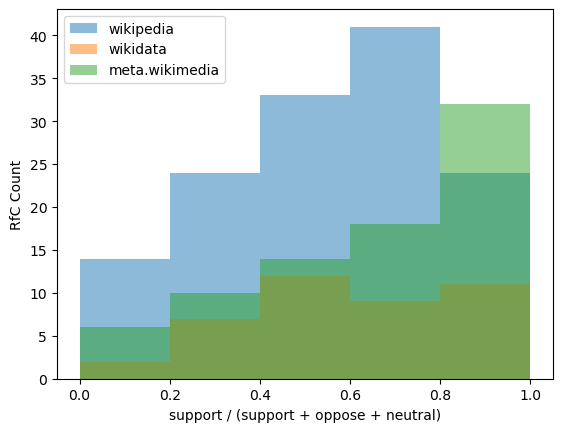

In [400]:
grouped = sentiment_df.groupby(['project', 'support_ratio']).size().reset_index(name='count')

# Get a list of all projects
projects = sentiment_df['project'].unique()

# Plot a histogram for each project
for project in projects:
    # Get the subset of data for this project
    subset = grouped[grouped['project'] == project]
    
    # Plot the histogram
    plt.hist(subset['support_ratio'], bins=5,alpha=0.5, label=project, width = 0.2)

# Add axis labels and a legend
plt.xlabel('support / (support + oppose + neutral)')
plt.ylabel('RfC Count')
plt.legend()
# Show the plot
plt.show()

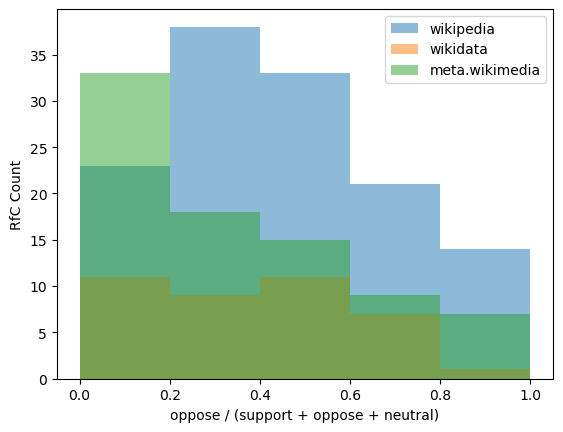

In [401]:
grouped = sentiment_df.groupby(['project', 'oppose_ratio']).size().reset_index(name='count')

# Get a list of all projects
projects = sentiment_df['project'].unique()

# Plot a histogram for each project
for project in projects:
    # Get the subset of data for this project
    subset = grouped[grouped['project'] == project]
    
    # Plot the histogram
    plt.hist(subset['oppose_ratio'], bins=5,alpha=0.5, label=project, width = 0.2)

# Add axis labels and a legend
plt.xlabel('oppose / (support + oppose + neutral)')
plt.ylabel('RfC Count')
plt.legend()
# Show the plot
plt.show()

In [402]:
sentiment_df = rfc_df.merge(sentiment_counts, on='rfc_id')
sentiment_df['support_ratio'] = sentiment_df['support'] / (sentiment_df['support'] + sentiment_df['oppose'] + sentiment_df['comment'] + sentiment_df['neutral'] + sentiment_df['unknown'])
sentiment_df['oppose_ratio'] = sentiment_df['oppose'] / (sentiment_df['support'] + sentiment_df['oppose'] + sentiment_df['comment'] + sentiment_df['neutral'] + sentiment_df['unknown'])
sentiment_df['support_ratio'].fillna(0, inplace=True)
sentiment_df['oppose_ratio'].fillna(0, inplace=True)

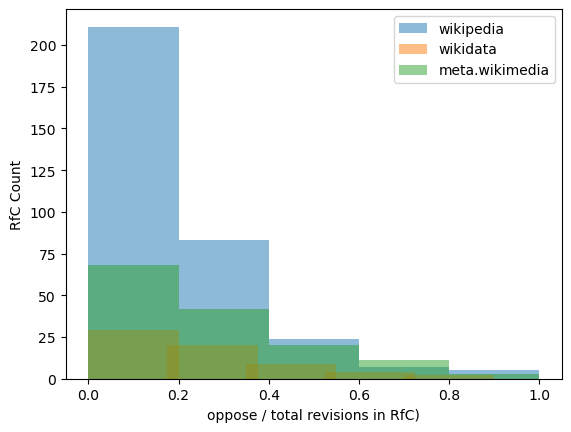

In [403]:
grouped = sentiment_df.groupby(['project', 'support_ratio']).size().reset_index(name='count')

# Get a list of all projects
projects = sentiment_df['project'].unique()

# Plot a histogram for each project
for project in projects:
    # Get the subset of data for this project
    subset = grouped[grouped['project'] == project]
    
    # Plot the histogram
    plt.hist(subset['support_ratio'], bins=5,alpha=0.5, label=project, width = 0.2)

# Add axis labels and a legend
plt.xlabel('oppose / total revisions in RfC)')
plt.ylabel('RfC Count')
plt.legend()
# Show the plot
plt.show()

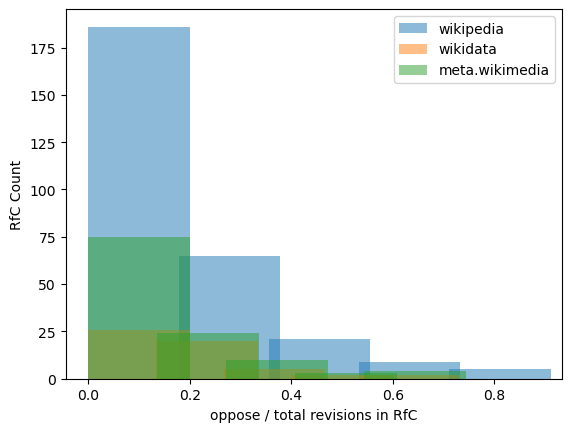

In [404]:
grouped = sentiment_df.groupby(['project', 'oppose_ratio']).size().reset_index(name='count')

# Get a list of all projects
projects = sentiment_df['project'].unique()

# Plot a histogram for each project
for project in projects:
    # Get the subset of data for this project
    subset = grouped[grouped['project'] == project]
    
    # Plot the histogram
    plt.hist(subset['oppose_ratio'], bins=5,alpha=0.5, label=project, width = 0.2)

# Add axis labels and a legend
plt.xlabel('oppose / total revisions in RfC')
plt.ylabel('RfC Count')
plt.legend()
# Show the plot
plt.show()

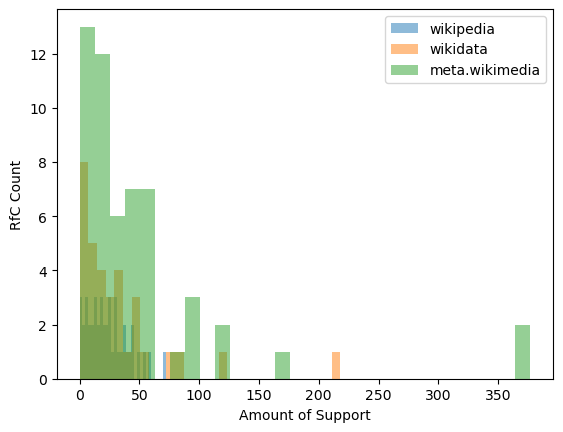

In [405]:
grouped = sentiment_df.groupby(['project', 'support']).size().reset_index(name='count')

# Get a list of all projects
projects = sentiment_df['project'].unique()

# Plot a histogram for each project
for project in projects:
    # Get the subset of data for this project
    subset = grouped[grouped['project'] == project]
    
    # Plot the histogram
    plt.hist(subset['support'], bins=30,alpha=0.5, label=project)

# Add axis labels and a legend
plt.xlabel('Amount of Support')
plt.ylabel('RfC Count')
plt.legend()
# Show the plot
plt.show()

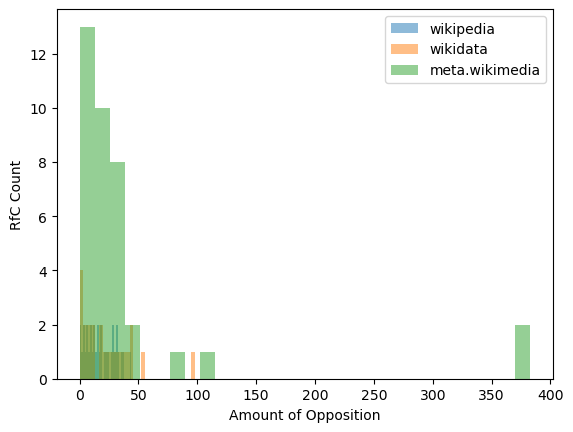

In [406]:
grouped = sentiment_df.groupby(['project', 'oppose']).size().reset_index(name='count')

# Get a list of all projects
projects = sentiment_df['project'].unique()

# Plot a histogram for each project
for project in projects:
    # Get the subset of data for this project
    subset = grouped[grouped['project'] == project]
    
    # Plot the histogram
    plt.hist(subset['oppose'], bins=30,alpha=0.5, label=project)

# Add axis labels and a legend
plt.xlabel('Amount of Opposition')
plt.ylabel('RfC Count')
plt.legend()
# Show the plot
plt.show()

In [407]:
grouped.head()

,project,oppose,count
0,meta.wikimedia,0,392
1,meta.wikimedia,1,46
2,meta.wikimedia,2,18
3,meta.wikimedia,3,14
4,meta.wikimedia,4,16


/tmp/ipykernel_13059/1471649611.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for project, group in grouped:


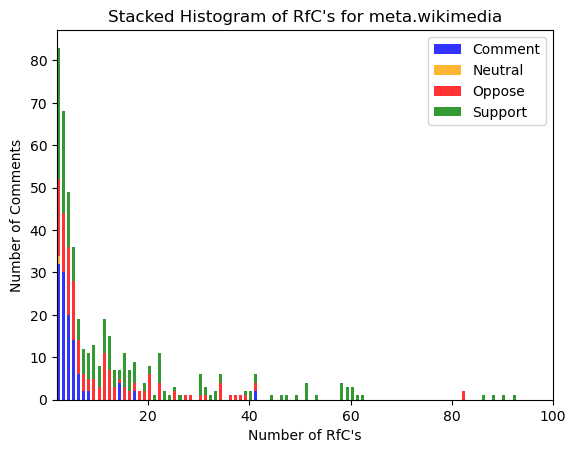

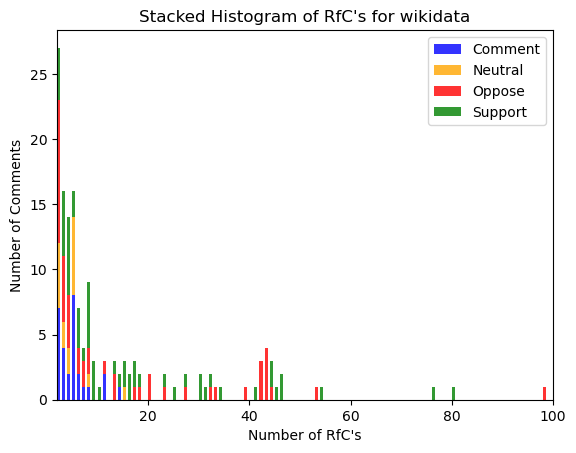

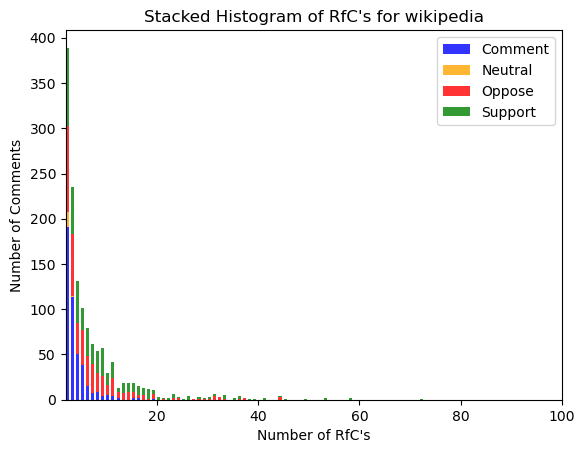

In [408]:
# merge comment dataframe with RFC dataframe
grouped = sentiment_df.groupby(['project'])

# Create a separate histogram for each project
for project, group in grouped:

    # Create a list of values for the stacked bars
    stacked_data = [
        group['comment'].values,
        group['neutral'].values,
        group['oppose'].values,
        group['support'].values,
    ]

    # Set the colors of the bars
    colors = ['b', 'orange', 'r', 'g']

    # Create a stacked histogram
    plt.hist(stacked_data, bins=range(2, len(group) + 2), stacked=True, alpha=0.8, color=colors, label=['Comment', 'Neutral', 'Oppose', 'Support'], width=0.6)

    # Set the title, x-axis label, and y-axis label
    plt.title(f'Stacked Histogram of RfC\'s for {project}')
    plt.xlabel('Number of RfC\'s')
    plt.ylabel('Number of Comments')
    # Set the range of the x-axis
    plt.xlim([2, 100])
    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

## How long are discussion active?

In [409]:
rfc_df = pd.read_csv('../data/rfc.csv')
comment_df = pd.read_csv('../data/rfc_comments.csv')
user_json = "../data/json_files/user_info/users.json"
with open(user_json) as f:
    users = json.load(f)
users_df = pd.DataFrame(users)

In [410]:
#fixing different date formats
from dateutil.parser import parse
# define a function to parse date strings using dateutil.parser
def parse_date(date_str):
    try:
        date = re.search(r'\d{2}:\d{2}, \d{1,2} \w+ \d{4} \(UTC\)', str(date_str))
        if date:
            # parse the input string into a datetime object
            input_datetime = datetime.strptime(date.group(), "%H:%M, %d %B %Y (%Z)")

            # format the datetime object in the desired output format
            return input_datetime.strftime("%Y-%m-%dT%H:%M:%SZ")
        else:
            return parse(date_str)
    except:
        return pd.NaT

# apply the parse_date function to the "date" column
comment_df['date'] = comment_df['date'].apply(parse_date)
# apply the parse_date function to the "date" column
rfc_df['closing_date'] = rfc_df['closing_date'].apply(parse_date)

# check the result
print(comment_df['date'])

0       2020-10-06 13:22:00+00:00
1       2020-10-07 06:22:00+00:00
2       2020-10-06 16:03:00+00:00
3       2020-10-06 16:27:00+00:00
4       2020-10-06 18:15:00+00:00
                   ...           
92249   2023-02-11 11:18:00+00:00
92250   2023-02-09 23:02:00+00:00
92251   2023-02-11 18:49:00+00:00
92252   2023-02-11 19:39:00+00:00
92253   2023-02-24 02:55:00+00:00
Name: date, Length: 92254, dtype: datetime64[ns, tzutc()]


In [411]:
rfc_df['closing_date'] = pd.to_datetime(rfc_df['closing_date'], utc=True)

In [412]:
# join the two dataframes based on the "id" and "discussion_input_comment" columns
merged_df = pd.merge(comment_df[['id', 'date']], rfc_df[['rfc_id', 'closing_date', 'discussion_input_comment','project']], left_on='id', right_on='discussion_input_comment')
# subtract datetime column from array of datetime values
merged_df['time_delta'] = merged_df['closing_date'] - merged_df['date']

In [413]:
# group the data by 'project' and calculate the mean of 'time_delta' for each group
avg_time = merged_df.groupby('project')['time_delta'].mean()

# print the average time for each project
print(avg_time)

project
meta.wikimedia   347 days 18:33:42.303370788
wikidata            315 days 19:45:37.500000
wikipedia         40 days 07:02:26.386010362
Name: time_delta, dtype: timedelta64[ns]


In [414]:
merged_df['time_delta'] = merged_df['time_delta'].dt.days

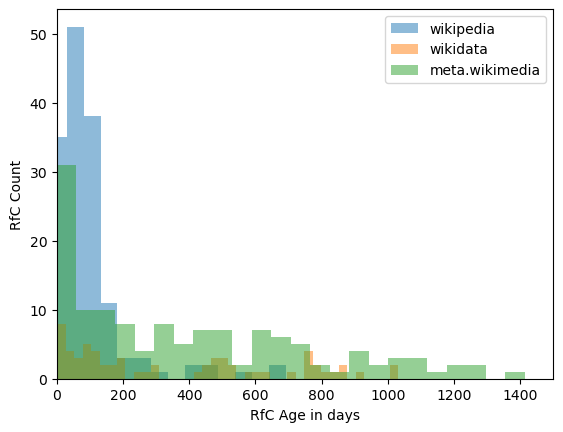

In [415]:
grouped = merged_df.groupby(['project', 'time_delta']).size().reset_index(name='count')

# Get a list of all projects
projects = merged_df['project'].unique()

# Plot a histogram for each project
for project in projects:
    # Get the subset of data for this project
    subset = grouped[grouped['project'] == project]
    
    # Plot the histogram
    plt.hist(subset['time_delta'], bins=40, alpha=0.5, label=project)

# Add axis labels and a legend
plt.xlabel('RfC Age in days')
plt.ylabel('RfC Count')
plt.legend()
plt.xlim([0, 1500])
# Show the plot
plt.show()

###  To what extent does the participants’ diversity influence the resolution of the deliberation?

In [416]:
merged_df = pd.merge(entropy, merged_df, on='rfc_id')
merged_df = pd.merge(delib_rfc_df, merged_df, on='rfc_id')

In [417]:
# Create a new column 'word_count' that contains the number of words in each comment
comment_df['word_count'] = comment_df['text'].str.split().str.len()

# Create a new dataframe that contains only comments with less than 5 words
short_comment_df = comment_df[comment_df['word_count'] < 5]

# Group by rfc_id and count the number of comments
count_df = short_comment_df.groupby('rfc_id').size().reset_index(name='comment_with_less_than_5_words_count')

# Display the count per rfc of comments with less than 5 words
print(count_df)
merged_df = pd.merge(count_df, merged_df, on='rfc_id')

     rfc_id  comment_with_less_than_5_words_count
0         5                                     1
1         9                                     1
2        15                                     1
3        24                                     1
4        27                                     1
..      ...                                   ...
642    2293                                     2
643    2294                                     3
644    2297                                     6
645    2298                                     2
646    2301                                     2

[647 rows x 2 columns]


In [418]:
# remove rows with NaN or infinite values
merged_df = merged_df.replace([np.inf, -np.inf], np.nan) # replace infinite values with NaN
merged_df = merged_df.dropna() # drop rows with NaN values
# group the data by project class
grouped = merged_df.groupby('project_x')

In [419]:
from scipy.stats import pearsonr

# loop through each group and calculate the correlation between entropy and deliberation
for name, group in grouped:
    # calculate the correlation coefficient and p-value
    corr, p_value = pearsonr(group['metric_diversity'], group['time_delta'])
    print('metric_diversity ~ time_delta')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = pearsonr(group['edit_diversity'], group['time_delta'])
    print('edit_diversity ~ time_delta')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = pearsonr(group['role_diversity'], group['time_delta'])
    print('role_diversity ~ time_delta')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = pearsonr(group['age_diversity'], group['time_delta'])
    print('age_diversity ~ time_delta')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = pearsonr(group['num_of_projects_editcount_50_diversity'], group['time_delta'])
    print('num_of_projects_editcount_50_diversity ~ time_delta')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

metric_diversity ~ time_delta
Correlation for class meta.wikimedia: Correlation coefficient: 0.10978684415038618 with p-value 0.24280447154261842


edit_diversity ~ time_delta
Correlation for class meta.wikimedia: Correlation coefficient: 0.13406855290240827 with p-value 0.15315474960069336


role_diversity ~ time_delta
Correlation for class meta.wikimedia: Correlation coefficient: -0.09219628640305699 with p-value 0.3270943356691156


age_diversity ~ time_delta
Correlation for class meta.wikimedia: Correlation coefficient: 0.11952281594021905 with p-value 0.2032652842191585


num_of_projects_editcount_50_diversity ~ time_delta
Correlation for class meta.wikimedia: Correlation coefficient: 0.0976666127194007 with p-value 0.2990834008031693


metric_diversity ~ time_delta
Correlation for class wikidata: Correlation coefficient: -0.44427233316561776 with p-value 0.015758376099943232


edit_diversity ~ time_delta
Correlation for class wikidata: Correlation coefficient: -0.4402921366576579

In [420]:
from scipy.stats import spearmanr

# loop through each group and calculate the correlation between entropy and deliberation
for name, group in grouped:
    # calculate the correlation coefficient and p-value
    corr, p_value = spearmanr(group['metric_diversity'], group['time_delta'])
    print('metric_diversity ~ time_delta')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = spearmanr(group['edit_diversity'], group['time_delta'])
    print('edit_diversity ~ time_delta')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = spearmanr(group['role_diversity'], group['time_delta'])
    print('role_diversity ~ time_delta')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = spearmanr(group['age_diversity'], group['time_delta'])
    print('age_diversity ~ time_delta')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = spearmanr(group['num_of_projects_editcount_50_diversity'], group['time_delta'])
    print('num_of_projects_editcount_50_diversity ~ time_delta')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

metric_diversity ~ time_delta
Correlation for class meta.wikimedia: Correlation coefficient: 0.07453710336591327 with p-value 0.42854058484959656


edit_diversity ~ time_delta
Correlation for class meta.wikimedia: Correlation coefficient: 0.11156887898989305 with p-value 0.23519494587796483


role_diversity ~ time_delta
Correlation for class meta.wikimedia: Correlation coefficient: -0.1249133888150658 with p-value 0.18347564096893157


age_diversity ~ time_delta
Correlation for class meta.wikimedia: Correlation coefficient: 0.06532256840406409 with p-value 0.4879360681032754


num_of_projects_editcount_50_diversity ~ time_delta
Correlation for class meta.wikimedia: Correlation coefficient: 0.031881896341233236 with p-value 0.735177596106193


metric_diversity ~ time_delta
Correlation for class wikidata: Correlation coefficient: -0.4314661513860935 with p-value 0.019438727995367343


edit_diversity ~ time_delta
Correlation for class wikidata: Correlation coefficient: -0.4371465872658188

## Is there a correlation between diversity and deliberation?

In [421]:
from scipy.stats import pearsonr

# loop through each group and calculate the correlation between entropy and deliberation
for name, group in grouped:
    # calculate the correlation coefficient and p-value
    corr, p_value = pearsonr(group['metric_diversity'], group['mean_dqi_value'])
    print('metric_diversity ~ mean_dqi_value')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = pearsonr(group['edit_diversity'], group['mean_dqi_value'])
    print('edit_diversity ~ mean_dqi_value')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = pearsonr(group['role_diversity'], group['mean_dqi_value'])
    print('role_diversity ~ mean_dqi_value')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = pearsonr(group['age_diversity'], group['mean_dqi_value'])
    print('age_diversity ~ mean_dqi_value')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = pearsonr(group['num_of_projects_editcount_50_diversity'], group['mean_dqi_value'])
    print('num_of_projects_editcount_50_diversity ~ mean_dqi_value')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

metric_diversity ~ mean_dqi_value
Correlation for class meta.wikimedia: Correlation coefficient: 0.1654981191278785 with p-value 0.07712915558496251


edit_diversity ~ mean_dqi_value
Correlation for class meta.wikimedia: Correlation coefficient: 0.1208659026496932 with p-value 0.19819687618027074


role_diversity ~ mean_dqi_value
Correlation for class meta.wikimedia: Correlation coefficient: -0.08335728691864015 with p-value 0.3757874493038369


age_diversity ~ mean_dqi_value
Correlation for class meta.wikimedia: Correlation coefficient: 0.20504152626757696 with p-value 0.027933711317306226


num_of_projects_editcount_50_diversity ~ mean_dqi_value
Correlation for class meta.wikimedia: Correlation coefficient: 0.1846835510982907 with p-value 0.04816537496559614


metric_diversity ~ mean_dqi_value
Correlation for class wikidata: Correlation coefficient: -0.2639709120139458 with p-value 0.1664551080021846


edit_diversity ~ mean_dqi_value
Correlation for class wikidata: Correlation coeffi

In [422]:
from scipy.stats import pearsonr

# loop through each group and calculate the correlation between entropy and deliberation
for name, group in grouped:
    # calculate the correlation coefficient and p-value
    corr, p_value = spearmanr(group['metric_diversity'], group['mean_dqi_value'])
    print('metric_diversity ~ mean_dqi_value')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = spearmanr(group['edit_diversity'], group['mean_dqi_value'])
    print('edit_diversity ~ mean_dqi_value')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = spearmanr(group['role_diversity'], group['mean_dqi_value'])
    print('role_diversity ~ mean_dqi_value')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = spearmanr(group['age_diversity'], group['mean_dqi_value'])
    print('age_diversity ~ mean_dqi_value')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

    corr, p_value = spearmanr(group['num_of_projects_editcount_50_diversity'], group['mean_dqi_value'])
    print('num_of_projects_editcount_50_diversity ~ mean_dqi_value')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")
    print("\n")

metric_diversity ~ mean_dqi_value
Correlation for class meta.wikimedia: Correlation coefficient: 0.16350313985246992 with p-value 0.08081246735929057


edit_diversity ~ mean_dqi_value
Correlation for class meta.wikimedia: Correlation coefficient: 0.08600413122882318 with p-value 0.3607636295329826


role_diversity ~ mean_dqi_value
Correlation for class meta.wikimedia: Correlation coefficient: -0.05620818398664742 with p-value 0.5507392053792848


age_diversity ~ mean_dqi_value
Correlation for class meta.wikimedia: Correlation coefficient: 0.2005697702180591 with p-value 0.031613410234416696


num_of_projects_editcount_50_diversity ~ mean_dqi_value
Correlation for class meta.wikimedia: Correlation coefficient: 0.18509443231153996 with p-value 0.04766085746354152


metric_diversity ~ mean_dqi_value
Correlation for class wikidata: Correlation coefficient: -0.259241036906824 with p-value 0.17446464977093046


edit_diversity ~ mean_dqi_value
Correlation for class wikidata: Correlation coeff

In [423]:
# loop through each group and calculate the correlation between entropy and deliberation
for name, group in grouped:
    # calculate the correlation coefficient and p-value
    corr, p_value = pearsonr(group['time_delta'], group['mean_dqi_value'])
    print('time_delta ~ mean_dqi_value')
    print(f"Correlation for class {name}: Correlation coefficient: {corr} with p-value {p_value}")

time_delta ~ mean_dqi_value
Correlation for class meta.wikimedia: Correlation coefficient: 0.05114888637267384 with p-value 0.5872164569144075
time_delta ~ mean_dqi_value
Correlation for class wikidata: Correlation coefficient: 0.28448766818461524 with p-value 0.13472459312631332
time_delta ~ mean_dqi_value
Correlation for class wikipedia: Correlation coefficient: 0.011072426299056724 with p-value 0.8244148971405514


In [424]:
for name, group in grouped:
    correlation = group['comment_with_less_than_5_words_count'].sum()
    print(f"Sum of short comments {name}: {correlation}")

Sum of short comments meta.wikimedia: 409
Sum of short comments wikidata: 355
Sum of short comments wikipedia: 639


meta.wikimedia


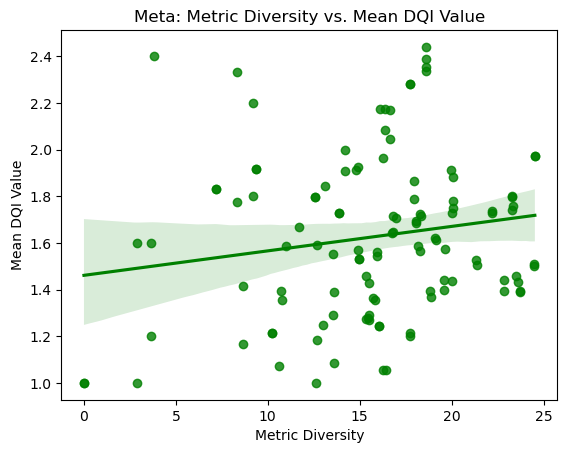

wikidata


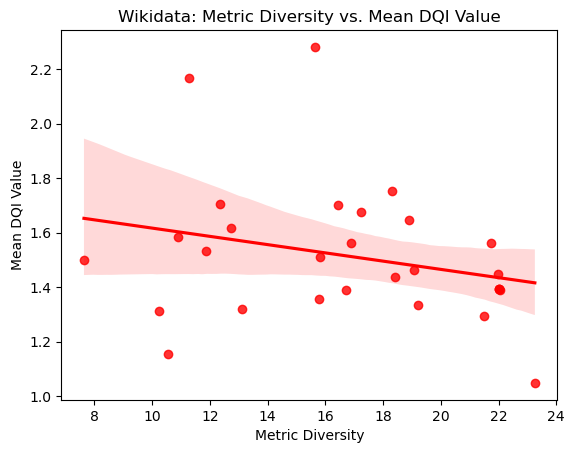

wikipedia


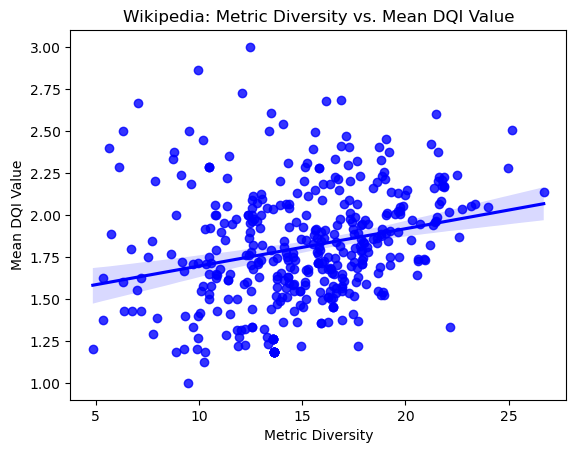

In [425]:
import matplotlib.pyplot as plt
import seaborn as sns

for name, group in grouped:

        # Assuming the DataFrame is called 'group'
        x = group['metric_diversity']
        y = group['mean_dqi_value']
        print(name)
        if(name == 'wikipedia'):
                sns.regplot(x=x, y=y, color='blue')
                plt.title('Wikipedia: Metric Diversity vs. Mean DQI Value')
        elif(name == 'wikidata'):
                sns.regplot(x=x, y=y, color='red')
                plt.title('Wikidata: Metric Diversity vs. Mean DQI Value')
        else:
                sns.regplot(x=x, y=y, color='green')
                plt.title('Meta: Metric Diversity vs. Mean DQI Value')
        
        plt.xlabel('Metric Diversity')
        plt.ylabel('Mean DQI Value')

        plt.show()

## Text Comparison

In [426]:
grouped = comment_df.groupby('project')
# create a dictionary of dataframes, with one dataframe for each unique value in the "class" column
dfs = {name: group for name, group in grouped}

# access each dataframe using its corresponding key
df_wikipedia_text = dfs['wikipedia']['text'].tolist()
df_wikidata_text = dfs['wikidata']['text'].tolist()
df_meta_text = dfs['meta.wikimedia']['text'].tolist()
# download the stopwords data if you haven't already
nltk.download('stopwords')

# get the set of English stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/dylan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [427]:
def remove_punctuation(txt):
    """Replace URLs and other punctuation found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with URLs and punctuation removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

def clean_text(txt):
    """Removes punctuation, changes to lowercase, removes
        stopwords, removes "animal" and "crossing", and
        calculates word frequencies.

    Parameters
    ----------
    txt : string
        A text string that you want to clean.

    Returns
    -------
    Words and frequencies
    """

    tmp = [remove_punctuation(t) for t in txt]
    tmp = [t.lower().split() for t in tmp]

    tmp = [[w for w in t if not w in stop_words]
                for t in tmp]
    tmp = [[w for w in t if not w in ['animal', 'crossing']]
                        for t in tmp]

    tmp = list(itertools.chain(*tmp))
    tmp = collections.Counter(tmp)
        
    return tmp

/home/dylan/anaconda3/envs/test_env/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


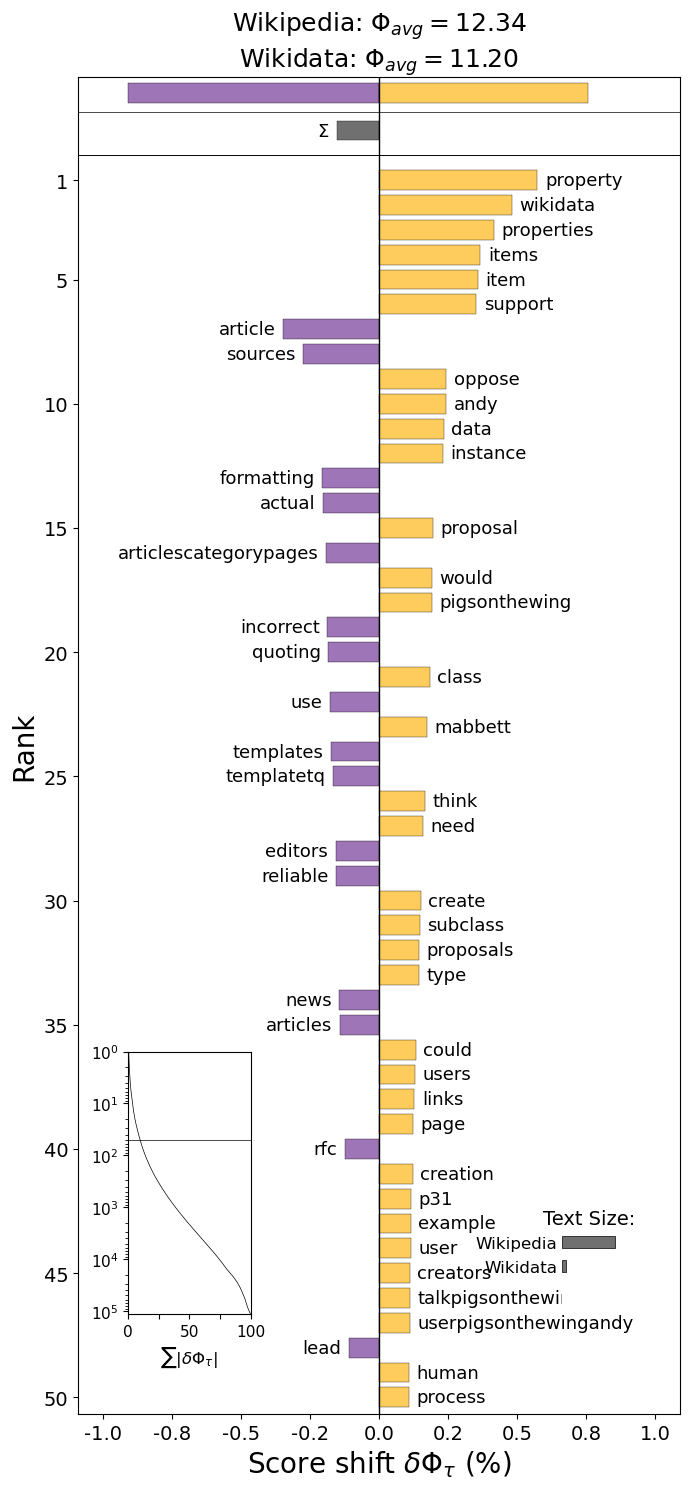

<Axes: title={'center': 'Wikipedia: $\\Phi_{avg}=$12.34\nWikidata: $\\Phi_{avg}=$11.20'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [428]:
clean_texts_wikipedia = clean_text(df_wikipedia_text)
clean_texts_wikidata = clean_text(df_wikidata_text)
clean_texts_meta = clean_text(df_meta_text)
entropy_shift = shifts.EntropyShift(clean_texts_wikipedia, clean_texts_wikidata, base = 2)
entropy_shift.get_shift_graph(system_names = ['Wikipedia', 'Wikidata']) 

/home/dylan/anaconda3/envs/test_env/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


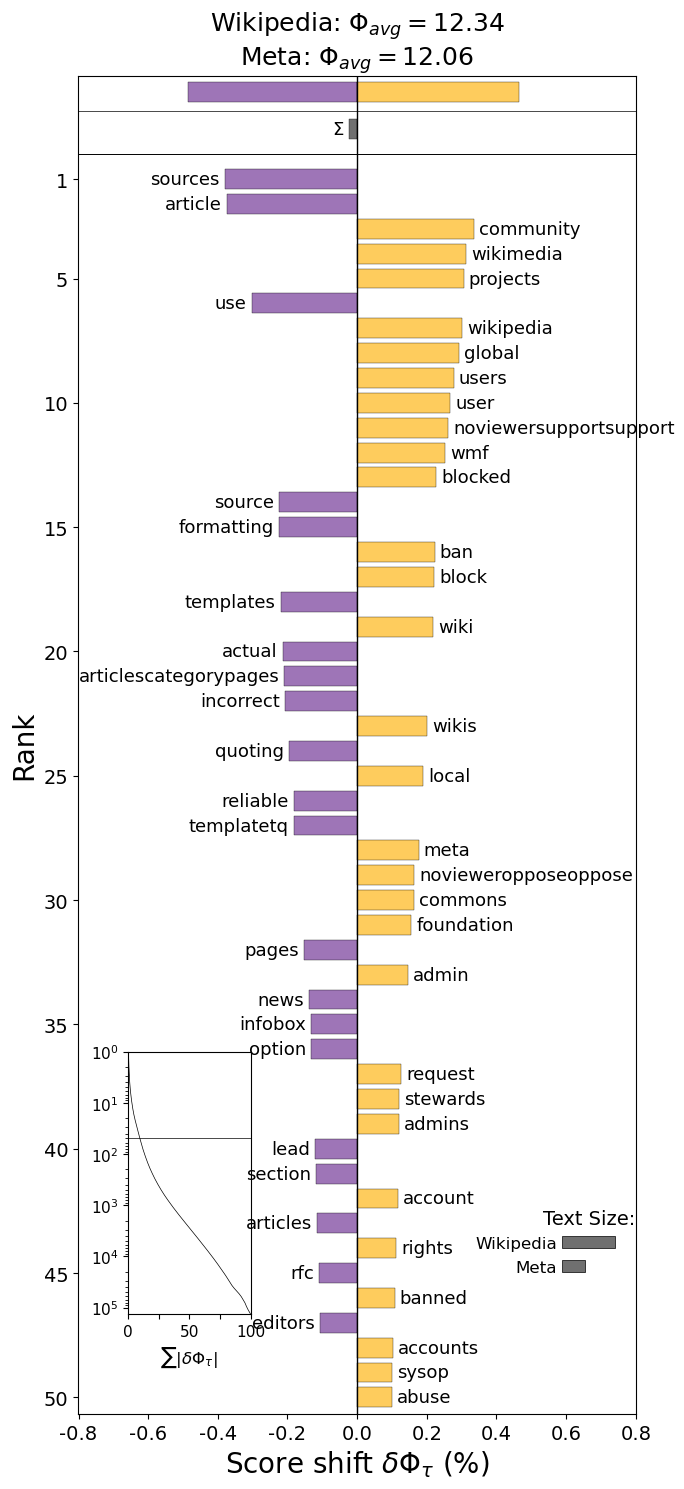

<Axes: title={'center': 'Wikipedia: $\\Phi_{avg}=$12.34\nMeta: $\\Phi_{avg}=$12.06'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [429]:
entropy_shift = shifts.EntropyShift(clean_texts_wikipedia, clean_texts_meta, base = 2)
entropy_shift.get_shift_graph(system_names = ['Wikipedia', 'Meta']) 

/home/dylan/anaconda3/envs/test_env/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


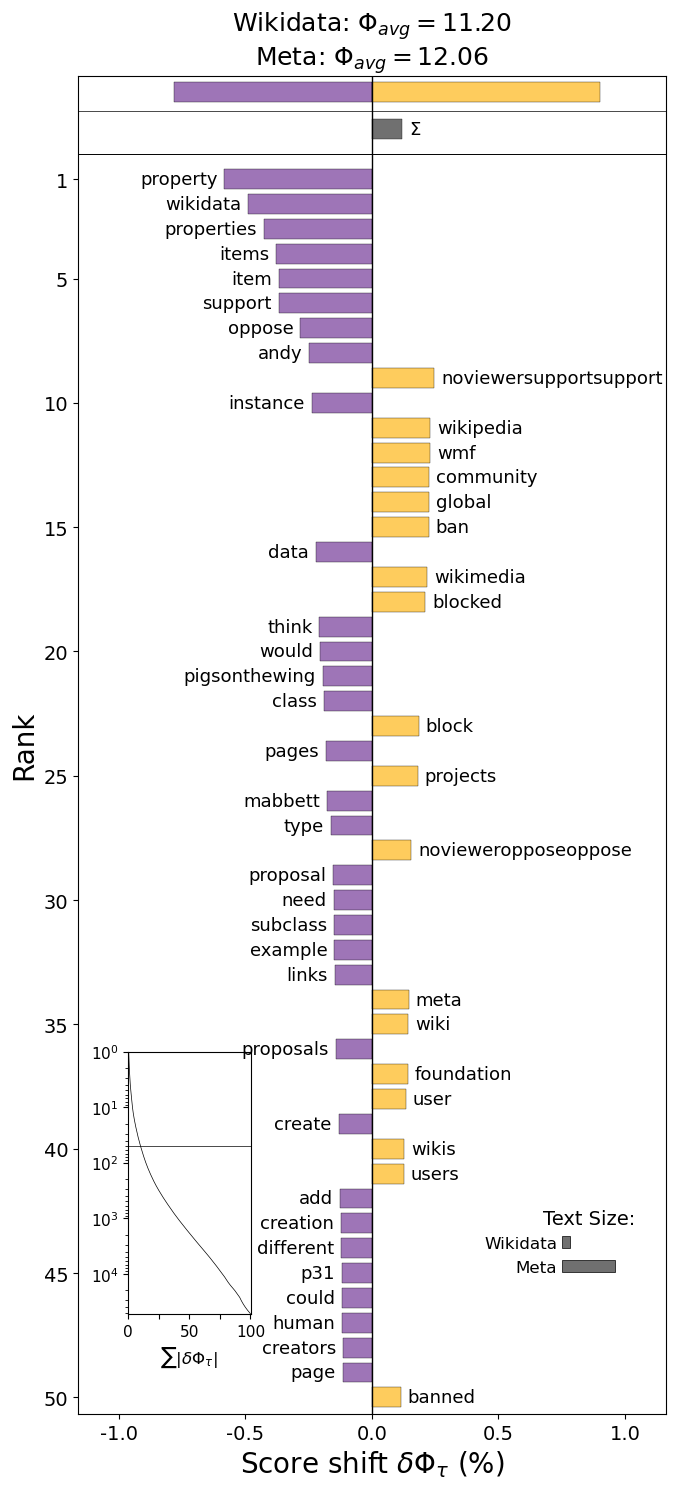

<Axes: title={'center': 'Wikidata: $\\Phi_{avg}=$11.20\nMeta: $\\Phi_{avg}=$12.06'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [430]:
entropy_shift = shifts.EntropyShift(clean_texts_wikidata, clean_texts_meta, base = 2)
entropy_shift.get_shift_graph(system_names = ['Wikidata', 'Meta']) 